# Extract data
Extract data from .csv files and store them in a database. Also create materialized views that will help creating prediction models

In [2]:
from f1predictions.database import clear_database
from f1predictions.etl.transformer import *

from f1predictions.etl.loader import load_data, load_view
import f1predictions.etl.view_definitions as viewdef


def load_models():
    print("Clearing database...")
    clear_database()

    print("Loading drivers...")
    load_data(get_drivers_transformer().transform_to_model())
    print("Loading circuits...")
    load_data(get_circuits_transformer().transform_to_model())
    print("Loading statuses...")
    load_data(get_statuses_transformer().transform_to_model())
    print("Loading constructors...")
    load_data(get_constructors_transformer().transform_to_model())
    print("Loading races...")
    load_data(get_races_transformer().transform_to_model())
    print("Loading rounds...")
    load_data(get_rounds_transformer().transform_to_model())
    print("Loading drivers constructors...")
    load_data(get_drivers_constructors_transformer().transform_to_model())
    print("Loading drivers results...")
    load_data(get_race_drivers_results_transformer().transform_to_model())
    print("Loading constructors results...")
    load_data(get_race_constructors_results_transformer().transform_to_model())
    print("Loading qualifying results...")
    load_data(get_qualifying_results_transformer().transform_to_model())
    print("Loading lap times...")
    load_data(get_lap_times_transformer().transform_to_model())
    print("Loading drivers standings...")
    load_data(get_drivers_standings_transformer().transform_to_model())
    print("Loading constructor standings...")
    load_data(get_constructors_standings_transformer().transform_to_model())
    print("Loading saved drivers ratings...")
    load_data(get_drivers_ratings_transformer().transform_to_model())


def create_materialized_views():
    print('Creating drivers season results data materialized view')
    load_view(viewdef.drivers_seasons_results_view)
    print('Creating drivers\' opponents season results data materialized view')
    load_view(viewdef.opponents_seasons_results_view)
    print('Creating drivers round results data materialized view')
    load_view(viewdef.drivers_rounds_results_view)
    print('Creating drivers\' opponents round results data materialized view')
    load_view(viewdef.opponents_rounds_results_view)


if __name__ == '__main__':
    load_models()
    create_materialized_views()


Clearing database...
Loading drivers...
Loading circuits...
Loading statuses...
Loading constructors...
Loading races...
Loading rounds...
Loading drivers constructors...
Loading drivers results...
Loading constructors results...
Loading qualifying results...
Loading lap times...
Loading drivers standings...
Loading constructor standings...
Loading saved drivers ratings...
Creating drivers season results data materialized view
Creating drivers' opponents season results data materialized view
Creating drivers round results data materialized view
Creating drivers' opponents round results data materialized view


# Create driver ratings prediction models
Use views created above to create season rating prediction models.
The training model output will be taken from F1 [Power Rankings](https://www.formula1.com/en/latest/tags.power-rankings.699Peq5SC9zNGvwCkb1ln6.html)

## Model would look like this:

| wins | position | avg quali position | q2s | q3s | poles | front rows | podiums | dnfs | h2h quali | % constructor points |
|------|----------|--------------------|-----|-----|-------|------------|---------|------|-----------|----------------------|

### Description

- **q2**: Q2 appearance (top 15 in qualifying)
- **q3**: Q3 appearance (top 10 in qualifying)
- **poles**: pole positions
- **front rows**: pole positions or 2nd place in quali
- **dnfs**: 'did not finish'

In [3]:
import numpy as np
from f1predictions.orm.config.database import get_session
from f1predictions.prediction.modelfactory import DriverRatingsModelFactory
from f1predictions.orm.query import DriverRatingQuery, DriverQuery
from f1predictions.prediction.regressors import LinearRegressorBuilder, DecisionTreeRegressorBuilder, \
    RandomForestRegressorBuilder

driver_rating_query = DriverRatingQuery(get_session())
factory = DriverRatingsModelFactory(DriverQuery(get_session()))

ratings = driver_rating_query.get_drivers_ratings()

model = [factory.create_driver_ratings_model(i.driver_id, i.year) for i in ratings]

X = np.array([i.to_list() for i in model])
y = np.array([i.rating for i in ratings])

drivers_ids = [i.driver_id for i in ratings]

linear_regression = (LinearRegressorBuilder()
    .set_model(X, y)
    .create_train_test_set(0.33)
    .create_regressor()
    )

print(linear_regression.get().score(X, y))
print(linear_regression.get().score(linear_regression.X_test, linear_regression.y_test))

decision_tree = (DecisionTreeRegressorBuilder()
    .set_model(X, y)
    .set_criterion('absolute_error')
    .create_train_test_set(0.33)
    .create_regressor(12)
    )

print(decision_tree.get().score(X, y))
print(decision_tree.get().score(decision_tree.X_test, decision_tree.y_test))

random_forest = (RandomForestRegressorBuilder()
    .set_model(X, y)
    .set_criterion('absolute_error')
    .create_train_test_set(0.33)
    .create_regressor(12)
    )

print(random_forest.get().score(X, y))
print(random_forest.get().score(random_forest.X_test, random_forest.y_test))

8.8
{'wins': 15, 'position': 1, 'average_quali_position': 2.590909090909091, 'q2s': 22, 'q3s': 22, 'poles': 8, 'front_rows': 14, 'podiums': 17, 'dnfs': 2, 'head_to_head_qualifying': 1, 'percentage_constructor_points': 59.806629834254146}


0.5416666666666666
0.7916666666666666
0.7083333333333334
0.625
0.4166666666666667


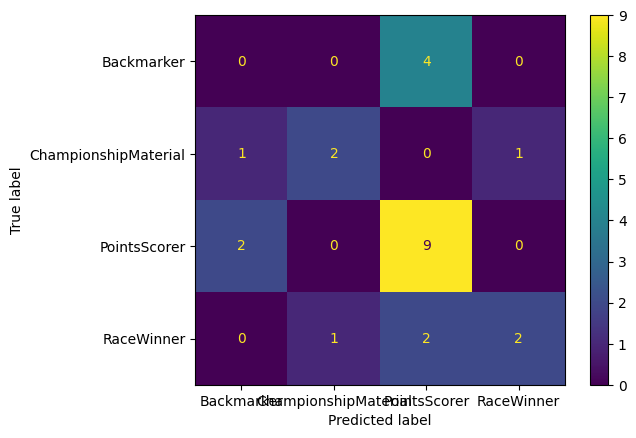

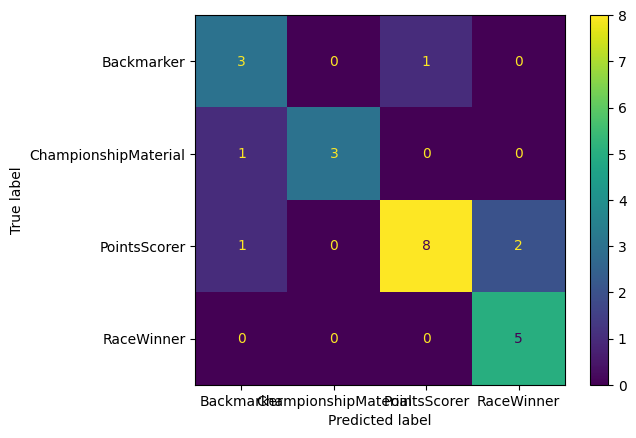

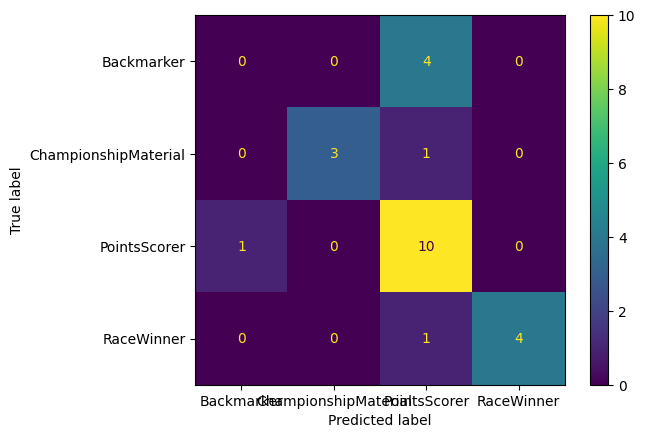

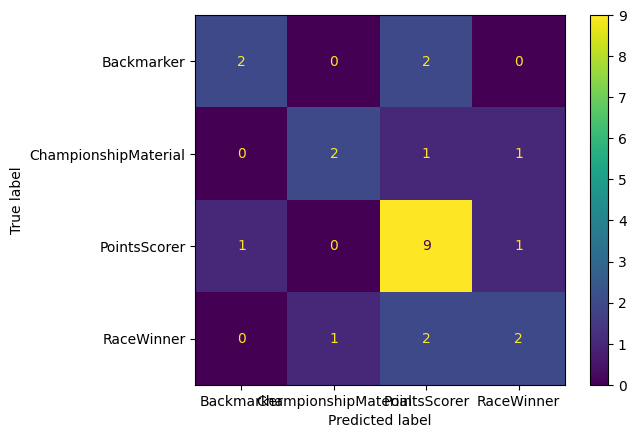

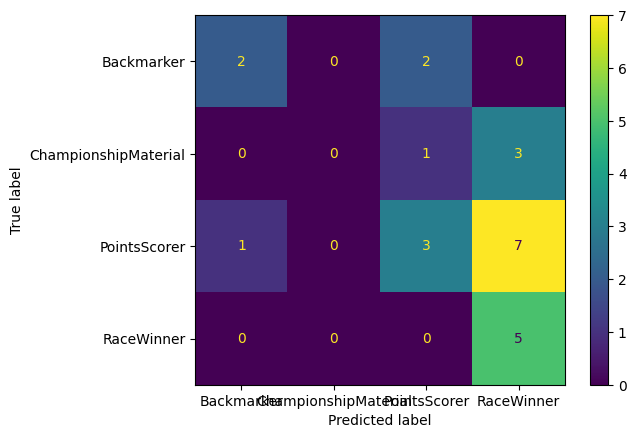

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import warnings
from f1predictions.orm.config.database import get_session
from f1predictions.orm.query import DriverCategoryQuery, DriverQuery, DriverRatingQuery
from f1predictions.prediction.modelfactory import DriverCategoryModelFactory, DriverRatingsModelFactory
from f1predictions.prediction.classifiers import LogisticRegressionClassifierBuilder, DecisionTreeClassifierBuilder, \
    RandomForestClassifierBuilder, LightGBMClassifierBuilder, KNNClassifierBuilder
from f1predictions.utils import get_driver_ratings_predictor

driver_categories_query = DriverCategoryQuery(get_session())
driver_ratings_factory = DriverRatingsModelFactory(DriverQuery(get_session()))
factory = DriverCategoryModelFactory(driver_ratings_factory)
ratings_predictor = get_driver_ratings_predictor(DriverRatingQuery(get_session()), driver_ratings_factory).get()

categories = driver_categories_query.get_drivers_categories()

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    model = [
        factory.create_driver_category_model(
            i.driver_id,
            i.year,
            float(ratings_predictor.predict(np.array(driver_ratings_factory.create_driver_ratings_model(i.driver_id, i.year).to_list()).reshape(1, -1))))
        for i in categories
    ]

X = np.array([i.to_list() for i in model])
y = np.array([i.category.name for i in categories])

drivers_ids = [i.driver_id for i in categories]

classifier_builder = LogisticRegressionClassifierBuilder() \
    .set_model(X, y) \
    .create_train_test_set(0.33) \
    .create_classifier('ovr', 'liblinear')

classifier = classifier_builder.get()

y_pred = classifier.predict(classifier_builder.X_test)
print(classifier.score(classifier_builder.X_test, classifier_builder.y_test))
ConfusionMatrixDisplay.from_predictions(classifier_builder.y_test, y_pred)

decision_tree_builder = DecisionTreeClassifierBuilder() \
    .set_model(X, y) \
    .set_criterion('log_loss') \
    .create_train_test_set(0.33) \
    .create_classifier(12)

decision_tree = decision_tree_builder.get()

y_pred = decision_tree.predict(decision_tree_builder.X_test)
print(decision_tree.score(decision_tree_builder.X_test, decision_tree_builder.y_test))
ConfusionMatrixDisplay.from_predictions(decision_tree_builder.y_test, y_pred)

random_forest_builder = RandomForestClassifierBuilder() \
    .set_model(X, y) \
    .set_criterion('log_loss') \
    .create_train_test_set(0.33) \
    .create_classifier(50)

random_forest = random_forest_builder.get()

y_pred = random_forest.predict(random_forest_builder.X_test)
print(random_forest.score(random_forest_builder.X_test, random_forest_builder.y_test))
ConfusionMatrixDisplay.from_predictions(random_forest_builder.y_test, y_pred)

lightgbm_builder = LightGBMClassifierBuilder() \
    .set_model(X, y) \
    .create_train_test_set(0.33) \
    .create_classifier(8)

lightgbm_classifier = lightgbm_builder.get()

y_pred = lightgbm_classifier.predict(lightgbm_builder.X_test)
print(lightgbm_classifier.score(lightgbm_builder.X_test, lightgbm_builder.y_test))
ConfusionMatrixDisplay.from_predictions(lightgbm_builder.y_test, y_pred)

knn_builder = KNNClassifierBuilder() \
    .set_model(X, y) \
    .create_train_test_set(0.33) \
    .create_classifier(25)

knn_classifier = knn_builder.get()

y_pred = knn_classifier.predict(knn_builder.X_test)
print(knn_classifier.score(knn_builder.X_test, knn_builder.y_test))
ConfusionMatrixDisplay.from_predictions(knn_builder.y_test, y_pred)

plt.show()
